# Customer Transaction Forecasting with Seq2Seq GRU Models

## 1. Loading & Processing Datasets

In [1]:
import pandas as pd


#electronic retailer data
df_electronic = pd.read_csv(
    filepath_or_buffer='_data/electronic_retailer.csv', 
    usecols=['Id', 'Date'],
    parse_dates=['Date']
).rename(columns={'Id': 'account_id', 'Date': 'date'})

earliest_date_electronic = '1998-12-01'
latest_date_electronic = '2004-11-30'


#gift retailer data
df_gift = pd.read_csv(
    filepath_or_buffer='_data/gift_retailer.csv', 
    sep=';', 
    usecols=['ID', 'date'],
    parse_dates=['date']
).rename(columns={'ID': 'account_id', 'date': 'date'})

earliest_date_gift = '2001-01-01'
latest_date_gift = '2007-12-30'


#multichannel retailer data
df_multichannel = pd.read_csv(
    filepath_or_buffer='_data/multichannel_retailer.csv',
    usecols=['CUSTNO', 'ORDER_DATE'],
    parse_dates=['ORDER_DATE'],
).rename(columns={'CUSTNO': 'account_id', 'ORDER_DATE': 'date'})

earliest_date_multichannel = '2005-01-01'
latest_date_multichannel = '2012-09-17'

#choose dataset: electronic, gift, or multichannel
#the training start corresponds to the earliest date in the chosen dataset
#the prediction end corresponds to the latest date in the chosen dataset
#The prediction start is chosen so [prediction_start, prediction_end] includes two years (see Example below)
#The training end is chosen to be one day before the prediction start (see Example below)
training_start = '1998-12-01'
training_end = '2002-12-31'
prediction_start = '2003-01-01'
prediction_end = '2004-11-30'

#assign df to the chosen dataset; drop_duplicates removes transactions happening on the same day
#for the same customer. Thus, a customer can make at most 7 transactions per week (max_trans = 7)
df = df_electronic.drop_duplicates()
max_trans = 7

In [3]:
import gc
from sklearn.model_selection import train_test_split

import preprocessing.transaction_df_to_timeseries as transaction_df_to_timeseries
import preprocessing.timeseries_to_one_hot as tsoh
import preprocessing.date_indexer as di

#transforming the transaction records during the training period [training_start, training_end]
#into customer transaction timeseries that are one-hot encoded
users_trans_ts, _ = transaction_df_to_timeseries.transform_trans_df_to_time_series(df, training_start, training_end, training_end)
users_trans_oh_ts = tsoh.time_series_to_one_hot(users_trans_ts, max_trans)

#the date indexer converts between indices and dates
# given a date in format yyyy-mm-dd returns the week index in users_trans_oh_ts containing the date;
# given a week index returns the earliest date contained in the week in format yyyy-mm-dd
date_indexer = di.DateIndexer(training_start, prediction_end)

#the customer transaction timeseries are split into training and validation sets.
#the validation set is used to tune the hyperparemeters. If there is no need to tune hyperparameters
#the data does not need to be split (see below)

#users_trans_train, users_trans_val = train_test_split(users_trans_oh_ts, test_size=0.1)
users_trans_train, users_trans_val = users_trans_oh_ts, users_trans_oh_ts
print(users_trans_oh_ts.shape, users_trans_train.shape, users_trans_val.shape)

#delete the unused arrays
del users_trans_ts
del users_trans_oh_ts
gc.collect()

Accounts in dataset:  19470
Total transactions: 63778


Preparing dataset:   0%|          | 0/19470 [00:00<?, ?it/s]

Converting to one-hot:   0%|          | 0/19470 [00:00<?, ?it/s]

(19470, 213, 60) (19470, 213, 60) (19470, 213, 60)


133

## 2. Sliding Window & Input-Label Pairs

In [4]:
import preprocessing.transactions_timeseries_dataset as ttd

#Choose/configure the sliding window parameterization (FOWS is recommended)

#FOWS
training_period_length = date_indexer[training_end] - date_indexer[training_start] + 1
input_size = training_period_length - 1
label_size = training_period_length - 1
label_offset = 1

#O5
# training_period_length = date_indexer[training_end] - date_indexer[training_start] + 1
# input_size = training_period_length - 5
# label_size = training_period_length - 1
# label_offset = 5

#O10
# training_period_length = date_indexer[training_end] - date_indexer[training_start] + 1
# input_size = training_period_length - 10
# label_size = training_period_length - 1
# label_offset = 10

#O20
# training_period_length = date_indexer[training_end] - date_indexer[training_start] + 1
# input_size = training_period_length - 20
# label_size = training_period_length - 1
# label_offset = 20

#O10S52
# training_period_length = date_indexer[training_end] - date_indexer[training_start] + 1
# input_size = training_period_length - 10 - (52 - 1)
# label_size = input_size + 9 #predict one year into the future
# label_offset = 10

#creating the training and validation input-label pairs
train_dataset = ttd.TransactionsTimeseriesDataset(users_trans_train, max_trans, input_size, label_size, label_offset)
val_dataset = ttd.TransactionsTimeseriesDataset(users_trans_val, max_trans, input_size, label_size, label_offset)

In [ ]:
import importlib
import numpy as np

## 3. Instantiate & Train Seq2Seq Model

In [5]:
import model_training.gru_model as gru

#creating model; hidden_size = 128 & num_layer = 1 is recommended
model = gru.GRU(
    hidden_size=128, num_layers=1,
    max_transactions=max_trans
    )

#configures how far and how many forecasts the model should make;
#depends on the sliding window parameterization and the resulting input-label pairs
model.set_label_specs(label_offset, label_size)

In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from model_training import train as tt

#Define Loss Function & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#Define the dataloaders
dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=32, shuffle=True)

#Choose the number of epochs for model training; for all sliding window parameterizations, 
#it is recommended to train for approximately 60 to 70 epochs. 
#however, for O10S52, a shorter training period of 5 to 6 epochs is recommended.
for _ in range(60): #1
    tt.train_one_epoch(dataloader_train, model, loss, optimizer, label_offset, label_size)
    tt.test(dataloader_val, model, loss)

Average loss: 1.990429  [   32/19470]
Average loss: 1.486946  [ 3264/19470]
Average loss: 0.122681  [ 6496/19470]
Average loss: 0.099258  [ 9728/19470]
Average loss: 0.090486  [12960/19470]
Average loss: 0.084576  [16192/19470]
Average loss: 0.080555  [19424/19470]
Test Error: Avg loss: 0.079886 

Average loss: 0.079656  [   32/19470]
Average loss: 0.077854  [ 3264/19470]
Average loss: 0.076439  [ 6496/19470]
Average loss: 0.076135  [ 9728/19470]
Average loss: 0.074510  [12960/19470]
Average loss: 0.072756  [16192/19470]
Average loss: 0.073227  [19424/19470]
Test Error: Avg loss: 0.071866 

Average loss: 0.070358  [   32/19470]
Average loss: 0.070095  [ 3264/19470]
Average loss: 0.071213  [ 6496/19470]
Average loss: 0.069148  [ 9728/19470]
Average loss: 0.069814  [12960/19470]
Average loss: 0.069822  [16192/19470]
Average loss: 0.069194  [19424/19470]
Test Error: Avg loss: 0.068098 

Average loss: 0.058138  [   32/19470]
Average loss: 0.067644  [ 3264/19470]
Average loss: 0.068102  [ 6

## 4. Forecasting

In [10]:
from clv_prediction import clv_predictor

#transforming the transaction records during the whole period [training_start, prediction_end]
#into customer transaction timeseries that are one-hot encoded
users_trans_ts, ids = transaction_df_to_timeseries.transform_trans_df_to_time_series(df, training_start, training_end, prediction_end)
users_trans_oh_ts = tsoh.time_series_to_one_hot(users_trans_ts, max_trans)

#predicts the transactions between [prediction_start, prediction_end] using the customer time series
#from [training_start, training_end]
predictor = clv_predictor.CLVPredictor(users_trans_oh_ts, ids, date_indexer, model, max_trans)
actual_trans, pred_trans = predictor.get_predictions_and_actual_transactions(prediction_start, prediction_end)

Accounts in dataset:  19470
Total transactions: 63778


Preparing dataset:   0%|          | 0/19470 [00:00<?, ?it/s]

Converting to one-hot:   0%|          | 0/19470 [00:00<?, ?it/s]

## 5. Error Metrics & Visualization

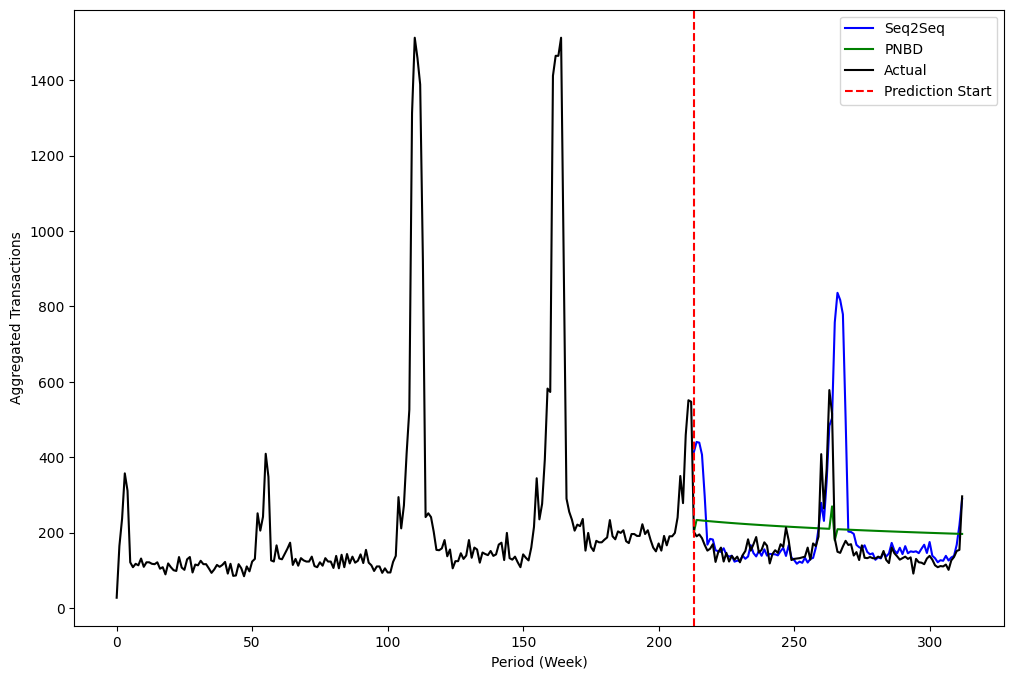

In [21]:
from clv_prediction import display, aggregation
from eval import conv_day_to_week_forecasts as cf


#actual aggregated transactions per week
actual_agg_trans = aggregation.create_agg_weekly_trans(actual_trans)


#forecast Seq2Seq
seq2seq_pred_agg_trans = aggregation.create_agg_weekly_trans(pred_trans)


#forecast PNBD
#the PNBD (CLVTools) forecasts were made daily and then aggregated into periods (weeks) so
#the Seq2Seq and PNBD periods contain the same days (see Section Dapa Preparation in the corresponding paper)
#!!!Pay attention to load the pnbd forecast of the right dataset!!!

pnbd_pred_agg_trans = pd.read_csv('_pnbd_benchmark_evaluations/pnbd_electronic.csv', parse_dates=['period.until'])
pnbd_pred_agg_trans = cf.convert_day_trans_to_week_trans(pnbd_pred_agg_trans, date_indexer, prediction_start, prediction_end)

#adding dummy values for the training period
pnbd_pred_agg_trans = torch.tensor((len(actual_agg_trans) - len(pnbd_pred_agg_trans)) * [0] + pnbd_pred_agg_trans)



#display actual, forecast Seq2Seq, and forecast PNBD
display.display_three(actual_agg_trans, seq2seq_pred_agg_trans, pnbd_pred_agg_trans, date_indexer, prediction_start)

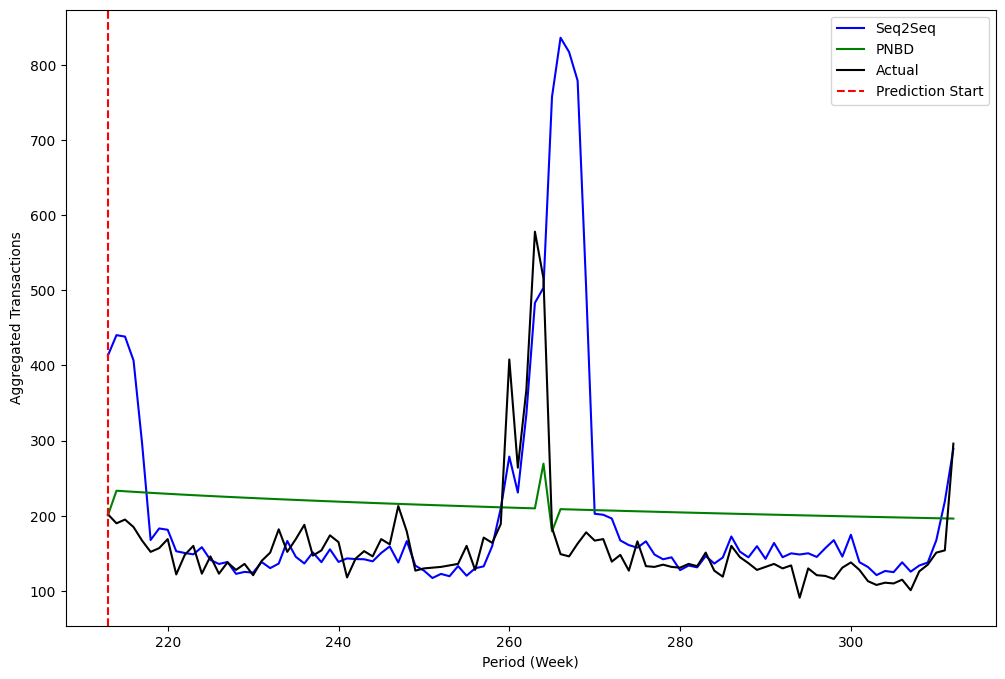

In [22]:
#display (only prediction period) actual, forecast Seq2Seq, and forecast PNBD 
display.display_prediction_period_three(actual_agg_trans, seq2seq_pred_agg_trans, pnbd_pred_agg_trans, date_indexer, prediction_start)

In [23]:
from eval import error_functions as ef
#calculate the three error metrics (RMSE, MAE, MAPE) for the PNBD and Seq2Seq model

pred_period_agg_trans = actual_agg_trans[date_indexer[prediction_start]:]
pred_period_seq2seq_trans = seq2seq_pred_agg_trans[date_indexer[prediction_start]:]
pred_period_pnbd_trans = pnbd_pred_agg_trans[date_indexer[prediction_start]:]

print(f'--------------------Seq2Seq Errors-------------------')
ef.print_errors(pred_period_agg_trans, pred_period_seq2seq_trans)
print(f'--------------------PNBD Errors-------------------')
ef.print_errors(pred_period_agg_trans, pred_period_pnbd_trans)

--------------------Seq2Seq Errors-------------------
calc_RMSE: 143.09080505371094
calc_MAE: 58.24830627441406
calc_MAPE: 35.6404914855957
--------------------PNBD Errors-------------------
calc_RMSE: 85.50324249267578
calc_MAE: 73.55009460449219
calc_MAPE: 48.660247802734375
